# Predicting Aircraft Maneuvers to Evaluate the Reliability of Human Observers
---
## 2d Lt David Crow
## 25 May 2019
---

# Import necessary libraries

In [35]:
# primary libraries
import numpy as np
import pandas as pd
import seaborn as sns

# machine learning tools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import cohen_kappa_score as ck_score
from sklearn.metrics import balanced_accuracy_score as accuracy

# machine learning models
from sklearn.linear_model import LogisticRegression as LR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import RidgeClassifier as RC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB as BC

# other libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations
from timeit import default_timer as timer

%matplotlib inline

# Some parameters and options

In [36]:
random_state = 777
num_folds = 10
pd.set_option('display.max_colwidth', -1)
pd.set_option("display.max_rows", 1000)

# Load the full dataset

In [37]:
# let's make our features more human-readable
features = {
    "GAE/ACPHIR"  : "Roll",
    "GAE/THETAR"  : "Pitch",
    "GAE/ACPSIR"  : "Yaw",
    "GAE/ACALTF"  : "Altitude",
    "GAE/IAIRSPK" : "Airspeed",
    "GAE/Z1DOTF"  : "Vertical Velocity",
    "GAE/UBODYF"  : "X Acceleration",
    "GAE/VBODYF"  : "Y Acceleration",
    "GAE/WBODYF"  : "Z Acceleration",
    "CLASS"       : "Maneuver"
}

# we'll probably need these later
units = {
    "Roll"              : "$degrees$",
    "Pitch"             : "$degrees$",
    "Yaw"               : "$degrees$",
    "Altitude"          : "$feet$",
    "Airspeed"          : "$feet/second$",
    "Vertical Velocity" : "$feet/second$",
    "X Acceleration"    : "$feet/second^2$",
    "Y Acceleration"    : "$feet/second^2$",
    "Z Acceleration"    : "$feet/second^2$"
}

# pull in the dataset; rename and reorder the columns
df = pd.read_csv("data/data.csv")
df = df.rename(columns=features)
df = df[list(features.values())]

df.head(5)

,Roll,Pitch,Yaw,Altitude,Airspeed,Vertical Velocity,X Acceleration,Y Acceleration,Z Acceleration,Maneuver
0,0.0,0.0,0.0,1.00282,24.4128,0.0,41.1627,0.0,0.018963,takeoff
1,0.0,0.0,0.0,1.00282,25.4220,0.0,42.8643,0.0,0.019065,takeoff
2,0.0,0.0,0.0,1.00282,26.3392,0.0,44.4109,0.0,0.019056,takeoff
3,0.0,0.0,0.0,1.00282,27.3479,0.0,46.2662,0.0,0.019048,takeoff
4,0.0,0.0,0.0,1.00282,28.3564,0.0,47.9665,0.0,0.019038,takeoff


### Convert radians to degrees

In [38]:
for label in ["Roll", "Pitch", "Yaw"]:
    df[label] = df[label] * 180 / np.pi

pd.set_option("display.max_rows", 10)
df.sample(frac=1, random_state=random_state).reset_index(drop=True)

,Roll,Pitch,Yaw,Altitude,Airspeed,Vertical Velocity,X Acceleration,Y Acceleration,Z Acceleration,Maneuver
0,-25.769178,12.690213,354.454037,5615.25000,358.273,-66.198000,644.806,4.432570,86.741000,turn
1,0.000000,0.000000,0.000000,1.00282,127.580,0.000000,215.114,0.000000,0.022389,takeoff
2,-36.563187,-20.794013,18.805449,5816.75000,376.512,223.949000,683.399,3.367840,-21.724000,turn
3,-2.035072,13.214469,0.864977,4810.00000,173.138,-28.299000,310.413,-4.923480,43.718400,cruise
4,0.000000,2.357618,0.000000,1.09411,160.910,-0.438585,271.100,0.000000,10.722600,takeoff
...,...,...,...,...,...,...,...,...,...,...
4962,32.785848,7.849923,305.312593,1277.07000,442.527,-76.318600,759.428,-1.727470,33.915300,turn
4963,1.850436,37.265290,1.544597,3693.10000,125.524,-89.406200,217.149,-0.940392,52.920900,takeoff
4964,-69.271743,-10.305104,22.443559,6498.52000,323.577,106.764000,586.485,-14.587800,-33.482600,turn
4965,-55.623545,-0.954783,310.165546,2743.25000,433.347,12.780900,760.687,-5.845650,-8.357540,turn


# Explore the data

### Histograms

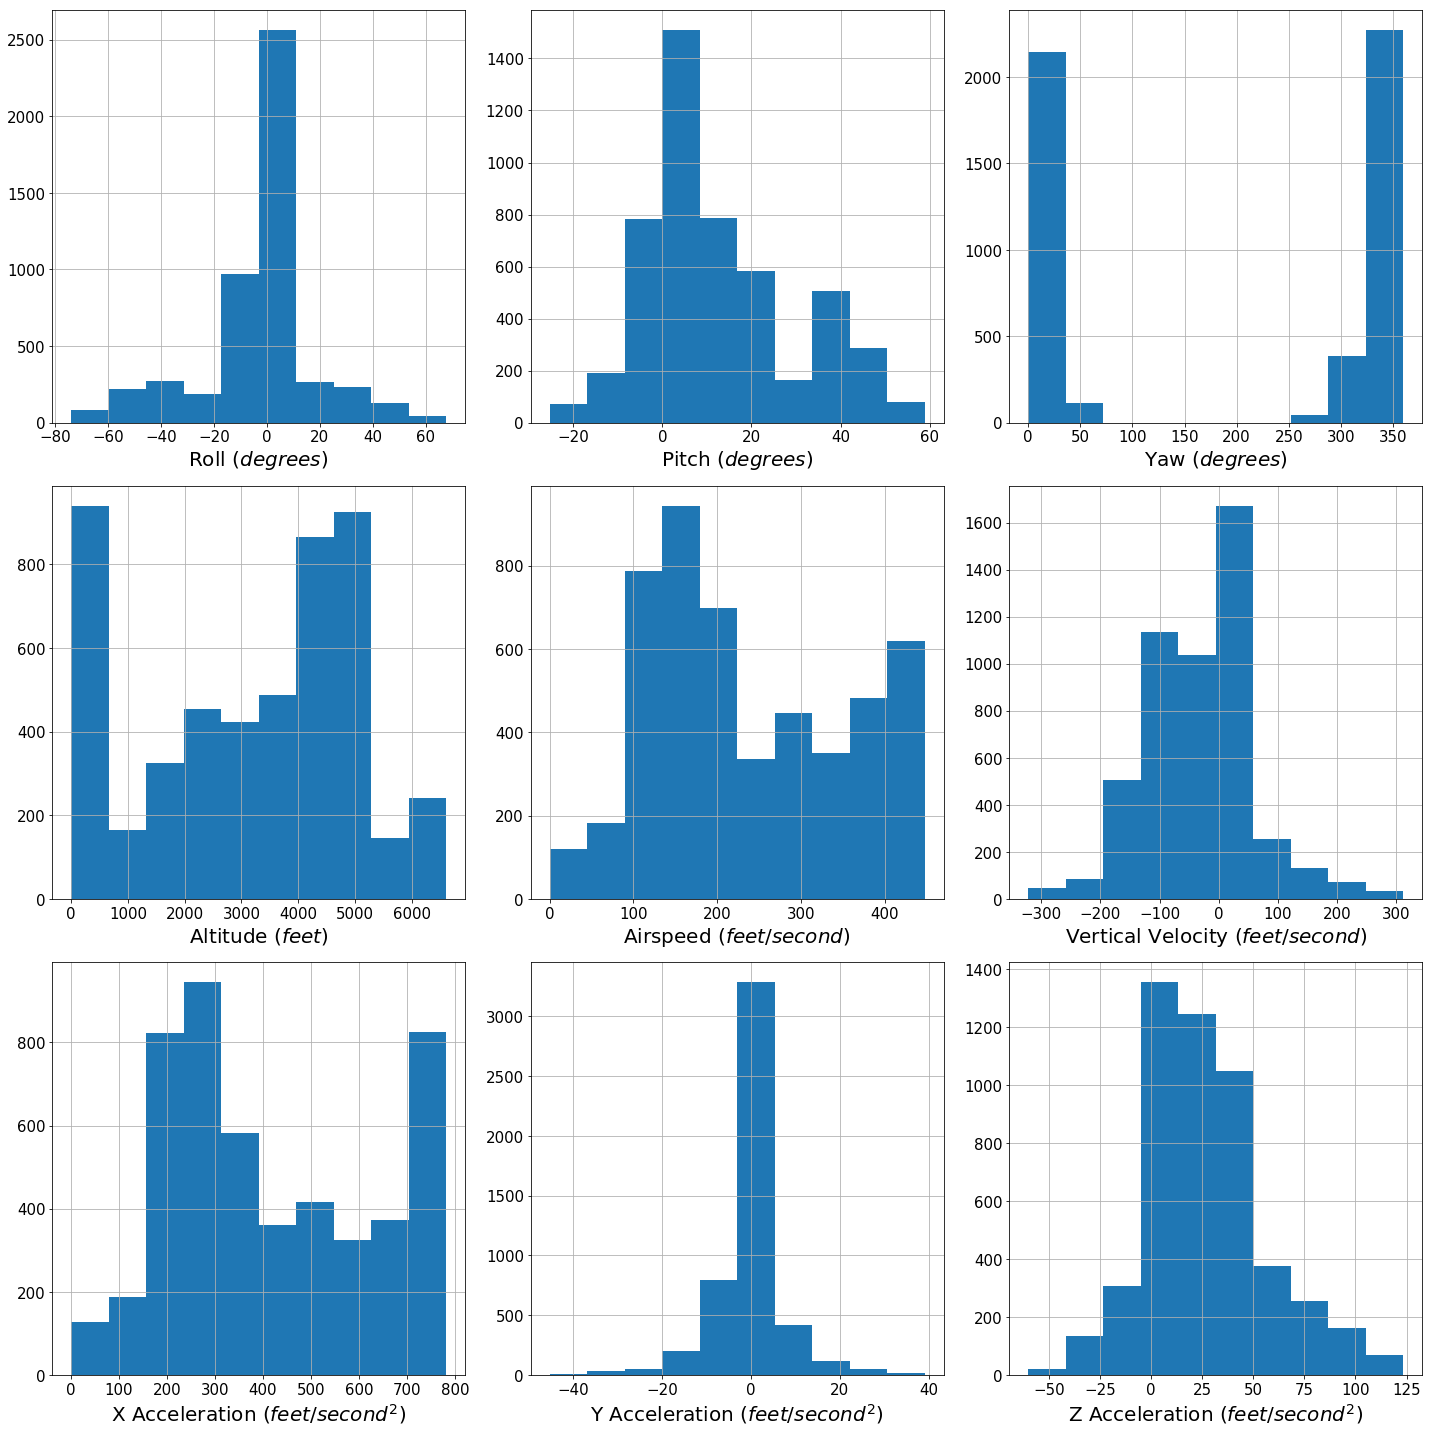

In [39]:
attributes = df.drop(columns=["Maneuver"]).columns

fig = plt.figure(figsize=(20,20))

# create a histogram for each feature
ax = []
for i, feature in enumerate(attributes):
    ax.append(fig.add_subplot(3, 3, i + 1))
    ax[i] = df[feature].hist()

    # change font sizes; label the x-axis with the feature and its units
    ax[i].set_xlabel(feature + " (" + units[feature] + ")", fontsize=20)
    ax[i].xaxis.set_tick_params(labelsize=15)
    ax[i].yaxis.set_tick_params(labelsize=15)

fig.tight_layout()
fig.savefig("figures/all-feature-histogram.png", dpi=200)

plt.show()

### Correlation scores

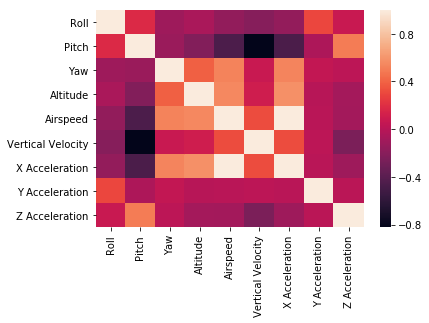

In [40]:
heatmap = sns.heatmap(df.corr())
plt.savefig("figures/corr.png", bbox_inches="tight", dpi=200)

### Three-dimensional scatter plots

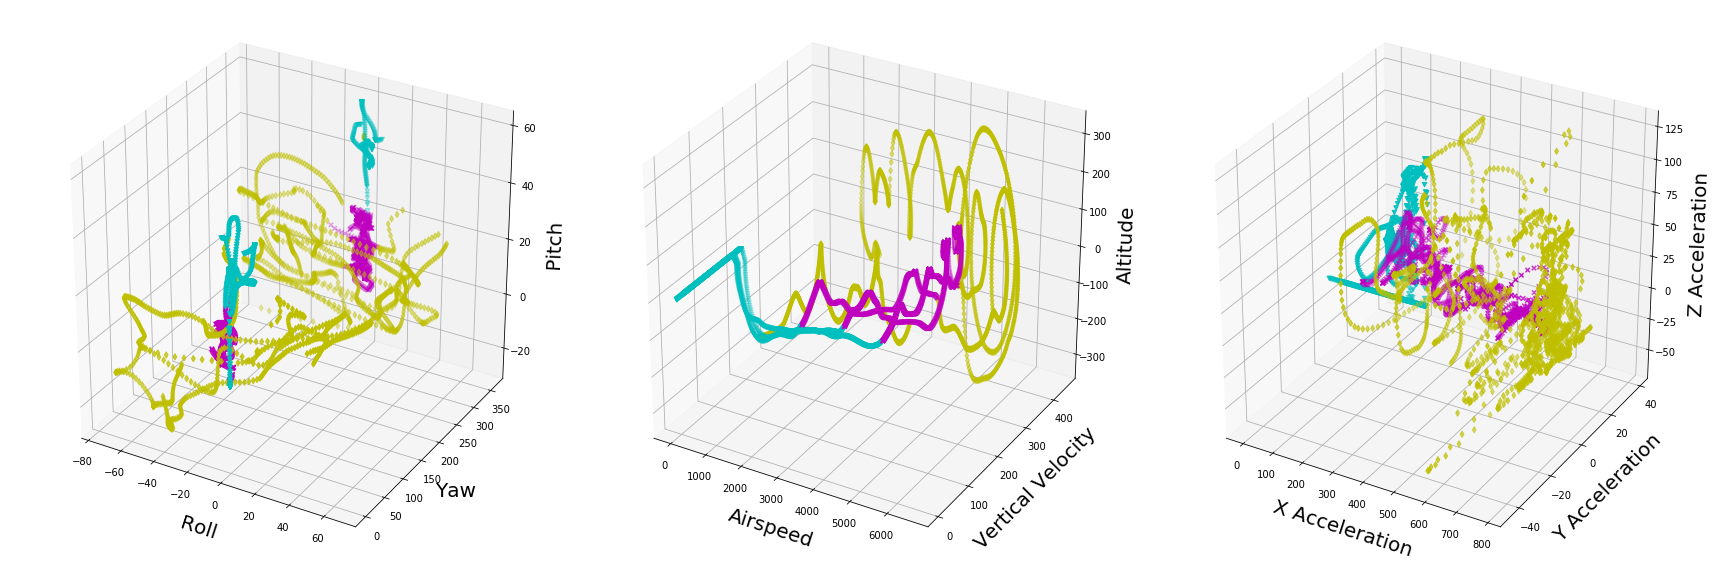

In [41]:
fig = plt.figure(figsize=(24,8))

# annotate our three plots (in all three axes)
labels_3d = [
    ["\nRoll", "\nYaw", "\nPitch"],
    ["\nAirspeed", "\nVertical Velocity", "\nAltitude"],
    ["\nX Acceleration", "\nY Acceleration", "\nZ Acceleration"]
]

# create the subplots
ax = [
    fig.add_subplot(131, projection='3d'),
    fig.add_subplot(132, projection='3d'),
    fig.add_subplot(133, projection='3d')
]

# label each axis and change its fontsize
for i, labels in enumerate(labels_3d):
    ax[i].set_xlabel(labels[0], fontsize=20)
    ax[i].set_ylabel(labels[1], fontsize=20)
    ax[i].set_zlabel(labels[2], fontsize=20)
    
    ax[i].xaxis.set_tick_params(labelsize=10)
    ax[i].yaxis.set_tick_params(labelsize=10)
    ax[i].zaxis.set_tick_params(labelsize=10)
    
# style stuff
markers = ['v', 'x', 'd']
colors = ['c', 'm', 'y']

# filter our dataset for each class
df_takeoff = df[df["Maneuver"] == "takeoff"]
df_cruise = df[df["Maneuver"] == "cruise"]
df_turn = df[df["Maneuver"] == "turn"]

# plot roll vs. yaw vs. pitch
ax[0].scatter(df_takeoff["Roll"], df_takeoff["Yaw"], df_takeoff["Pitch"],
    label="Takeoff", color=colors[0], marker=markers[0])
ax[0].scatter(df_cruise["Roll"], df_cruise["Yaw"], df_cruise["Pitch"],
    label="Cruise", color=colors[1], marker=markers[1])
ax[0].scatter(df_turn["Roll"], df_turn["Yaw"], df_turn["Pitch"],
    label="Turn", color=colors[2], marker=markers[2])

# plot altitude vs. airspeed vs. vertical velocity
ax[1].scatter(df_takeoff["Altitude"], df_takeoff["Airspeed"], df_takeoff["Vertical Velocity"],
    label="Takeoff", color=colors[0], marker=markers[0])
ax[1].scatter(df_cruise["Altitude"], df_cruise["Airspeed"], df_cruise["Vertical Velocity"], 
    label="Cruise", color=colors[1], marker=markers[1])
ax[1].scatter(df_turn["Altitude"], df_turn["Airspeed"], df_turn["Vertical Velocity"], 
    label="Turn", color=colors[2], marker=markers[2])

# plot x- vs. z- vs. y-acceleration
ax[2].scatter(df_takeoff["X Acceleration"], df_takeoff["Y Acceleration"], df_takeoff["Z Acceleration"],
    label="Takeoff", color=colors[0], marker=markers[0])
ax[2].scatter(df_cruise["X Acceleration"], df_cruise["Y Acceleration"], df_cruise["Z Acceleration"], 
    label="Cruise", color=colors[1], marker=markers[1])
ax[2].scatter(df_turn["X Acceleration"], df_turn["Y Acceleration"], df_turn["Z Acceleration"], 
    label="Turn", color=colors[2], marker=markers[2])

# # show the legends
# for a in ax:
#     a.legend(fontsize=20)

fig.tight_layout()
fig.savefig("figures/3d-plots.png", dpi=200)

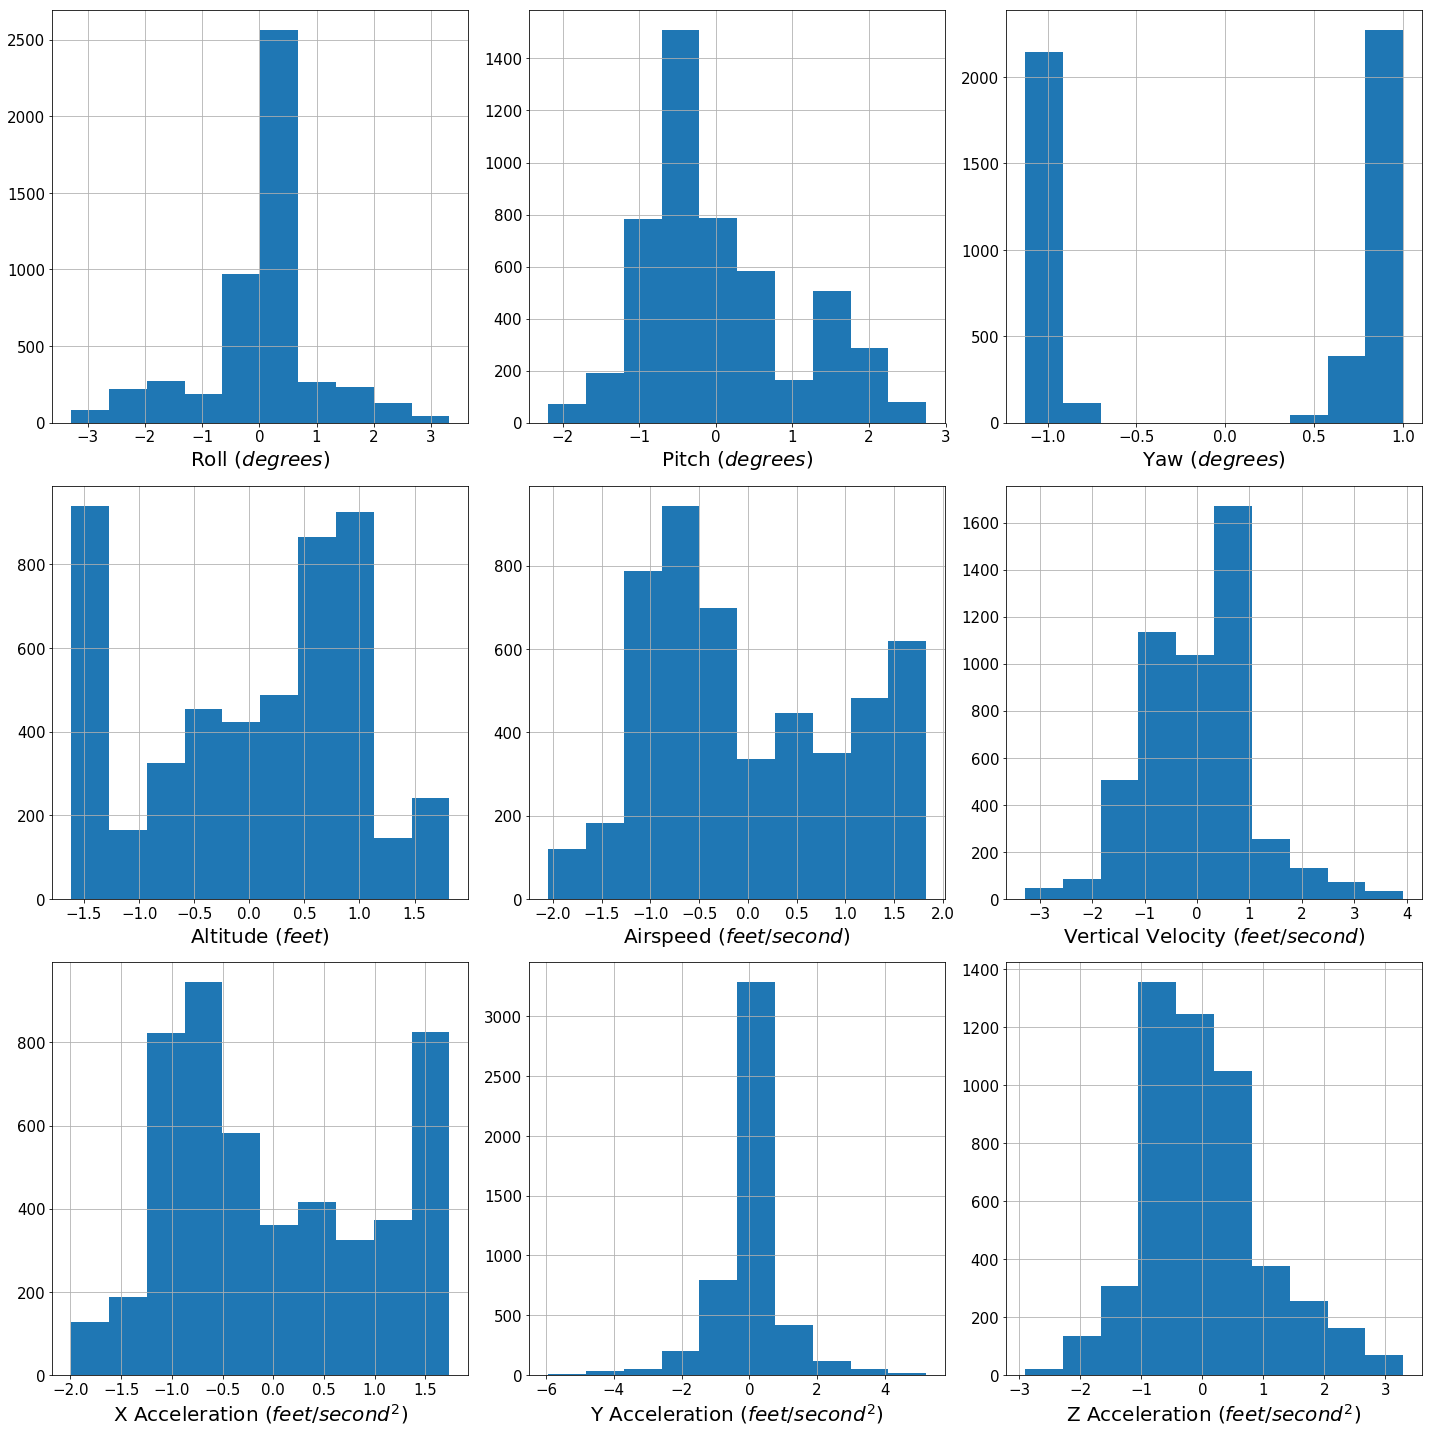

In [42]:
scaler = StandardScaler()
scaler.fit(df.drop(columns=["Maneuver"]))

df_scaled = pd.DataFrame(
    scaler.transform(df.drop(columns=["Maneuver"])),
    columns=df.drop(columns=["Maneuver"]).columns.values,
    index=df.index.values
)

fig = plt.figure(figsize=(20,20))

# create a histogram for each feature
ax = []
for i, feature in enumerate(df.drop(columns=["Maneuver"]).columns):
    ax.append(fig.add_subplot(3, 3, i + 1))
    ax[i] = df_scaled[feature].hist()

    # change font sizes; label the x-axis with the feature and its units
    ax[i].set_xlabel(feature + " (" + units[feature] + ")", fontsize=20)
    ax[i].xaxis.set_tick_params(labelsize=15)
    ax[i].yaxis.set_tick_params(labelsize=15)

fig.tight_layout()
fig.savefig("figures/slides-histogram.png", dpi=200)

plt.show()

# Drop the useless data

In [43]:
df = df.drop(columns=["Yaw"])
attributes = df.drop(columns=["Maneuver"]).columns

# Segregate the data

In [44]:
# split into training and testing data
train_size = int(len(df) * 0.90)
train, test = train_test_split(df, train_size=train_size, test_size=len(df)-train_size, random_state=random_state)

# split into x and y sets
train_x = train.drop(columns=["Maneuver"])
train_y = train["Maneuver"]

test_x = test.drop(columns=["Maneuver"])
test_y = test["Maneuver"]

# Build the expert system

In [47]:
# lol "expert"
def compute_expert_labels(dataset):
    labels = []
    
    for _, row in dataset.iterrows():
        if row["Roll"] <= -10 or row["Roll"] >= 10:
            labels.append("turn")
        elif row["Altitude"] < 2000:
            labels.append("takeoff")
        elif row["Pitch"] >= 20:
            labels.append("takeoff")
        else:
            labels.append("cruise")
    
    return labels

train_expert = compute_expert_labels(train_x)
test_expert = compute_expert_labels(test_x)

print("Cohen's Kappa Coefficient")
print("\tTraining set : {}".format(ck_score(train_expert, train_y)))
print("\tTesting set  : {}".format(ck_score(test_expert, test_y)))

print("Balanced Accuracy")
print("\tTraining set : {}".format(accuracy(train_expert, train_y)))
print("\tTesting set  : {}".format(accuracy(test_expert, test_y)))

Cohen's Kappa Coefficient
	Training set : 0.8788465999911406
	Testing set  : 0.9033579232648299
Balanced Accuracy
	Training set : 0.9198845731094067
	Testing set  : 0.9354291527284171


# Scale the data

In [48]:
# transform the training and testing sets
scaler = StandardScaler()
scaler.fit(train_x)
train_x_scaled = scaler.transform(train_x)
test_x_scaled = scaler.transform(test_x)

# put them back into usable dataframes
train_x = pd.DataFrame(train_x_scaled, columns=train_x.columns.values, index=train_x.index.values)
test_x = pd.DataFrame(test_x_scaled, columns=test_x.columns.values, index=test_x.index.values)

# Define the best subset selection method

In [49]:
def bestSubset(train_x, train_y, k, model):
    k_features = []
    k_ck_scores = []
    
    # identify all k-subsets of our attributes
    subsets = combinations(attributes, k)
    
    # for each k-subset...
    for subset in subsets:
        # initialize k-fold CV
        kf = KFold(n_splits=num_folds, shuffle=False, random_state=random_state)
        kf.get_n_splits(train_x)
        kfold_ck_scores = []
        
        # for each fold...
        for train_idx, test_idx in kf.split(train_x):
            # fit the model
            model.fit(train_x[list(subset)].iloc[train_idx], train_y.iloc[train_idx])

            # predict maneuver and compute Cohen's kappa
            kfold_ck_scores.append(ck_score(
                train_y.iloc[test_idx],
                model.predict(train_x[list(subset)].iloc[test_idx])
            ))
        
        # save the relevant results
        k_features.append(list(subset))
        k_ck_scores.append(abs(np.mean(kfold_ck_scores)))
        
    # return the minimum MSE and the related subset of attributes
    return (np.max(k_ck_scores), k_features[np.argmax(k_ck_scores)])

# Fit LR, LDA, and QDA

In [50]:
# save these for later
simple_model_names = []
simple_cohen_kappa_scores = []
simple_num_features = []
simple_best_features = []

# the various models we're going to fit
models = {
    "LR": LR(solver="liblinear", multi_class="ovr", random_state=random_state),
    "LDA": LDA(solver="lsqr"),
    "QDA": QDA()
}

# let's see how long this takes
start = timer()

for name in models:
    for i in range(1, len(attributes) + 1):
        s, f = bestSubset(train_x, train_y, i, models[name])
        
        simple_model_names.append(name)
        simple_cohen_kappa_scores.append(s)
        simple_num_features.append("num features: {}".format(i))
        simple_best_features.append("best features: {}".format(f))

print("\n", timer() - start, " seconds", sep="")


91.51773900500007 seconds


### Build a dataframe

In [51]:
simple_models = np.hstack((
    simple_model_names,
    simple_cohen_kappa_scores,
    simple_num_features,
    simple_best_features,
    np.full(len(simple_model_names), "-")
)).reshape(5, len(simple_model_names)).T

# Fit a ridge classifier

In [52]:
# let's see how long this takes
start = timer()

# save these for later
ridge_cohen_kappa_scores = []
ridge_alphas = []

alphas = np.logspace(-2, 3, num=20)

for alpha in alphas:
    ridge = RC(alpha=alpha, random_state=random_state)
    ridge.fit(train_x, train_y)
    
    ridge_cohen_kappa_scores.append(ck_score(test_y, ridge.predict(test_x)))
    ridge_alphas.append("alpha: {0:.6f}".format(alpha))

print("\n", timer() - start, " seconds", sep="")


0.2188237399998343 seconds


### Build a dataframe

In [53]:
ridge_model = np.hstack((
    np.full(len(ridge_cohen_kappa_scores), "RC"),
    ridge_cohen_kappa_scores,
    ridge_alphas,
    np.full(len(ridge_cohen_kappa_scores), "-"),
    np.full(len(ridge_cohen_kappa_scores), "-")
)).reshape(5, len(ridge_cohen_kappa_scores)).T

# Fit a classification tree

In [54]:
# save these for later
tree_cohen_kappa_scores = []
tree_max_depths = []
tree_num_features = []
tree_best_features = []

# let's see how long this takes
start = timer()

# for every depth...
for d in range(1, 21):
    # for every number of features...
    for f in range(1, int(np.sqrt(len(attributes))) + 1):
        # initialize k-fold CV
        kf = KFold(n_splits=num_folds, shuffle=False, random_state=random_state)
        kf.get_n_splits(train_x)

        # initialize random forest regression
        model = RFC(max_depth=d, max_features=f, n_estimators=50, random_state=random_state)
        kfold_ck_scores = []

        # for every fold...
        for train_idx, test_idx in kf.split(train_x):
            # fit the classification model
            model.fit(train_x.iloc[train_idx], train_y.iloc[train_idx])

            # predict maneuver and compute Cohen's kappa
            kfold_ck_scores.append(ck_score(train_y.iloc[test_idx], model.predict(train_x.iloc[test_idx])))
            
        # save these for later
        tree_cohen_kappa_scores.append(np.mean(kfold_ck_scores))
        tree_max_depths.append("max depth: {}".format(d))
        tree_num_features.append("max features: {}".format(f))
        
        # build a nice dataframe
        importances = pd.DataFrame(
            model.feature_importances_,
            columns=["Importance"],
            index=attributes
        )

        # sort the dataframe and save the best f features
        importances = importances.sort_values(by=["Importance"], ascending=False)
        tree_best_features.append("best features: {}".format(list(importances.index[:f])))
        
print("\n", timer() - start, " seconds", sep="")


60.728134067000155 seconds


### Build a dataframe

In [55]:
tree_model = np.hstack((
    np.full(len(tree_cohen_kappa_scores), "RFC"),
    tree_cohen_kappa_scores,
    tree_max_depths,
    tree_best_features,
    tree_num_features
)).reshape(5, len(tree_cohen_kappa_scores)).T

# Fit k-nearest neighbors

In [56]:
# save these for later
knn_cohen_kappa_scores = []
knn_num_neighbors = []

# let's see how long this takes
start = timer()

# for every number of neighbors...
for n in range(1, 51):
    # initialize k-fold CV
    kf = KFold(n_splits=num_folds, shuffle=False, random_state=random_state)
    kf.get_n_splits(train_x)

    # initialize knn
    model = KNN(n_neighbors=n)
    kfold_ck_scores = []

    # for every fold...
    for train_idx, test_idx in kf.split(train_x):
        # fit the classification model
        model.fit(train_x.iloc[train_idx], train_y.iloc[train_idx])

        # predict maneuver and compute Cohen's kappa
        kfold_ck_scores.append(ck_score(train_y.iloc[test_idx], model.predict(train_x.iloc[test_idx])))

    # save these for later
    knn_cohen_kappa_scores.append(np.mean(kfold_ck_scores))
    knn_num_neighbors.append("neighbors: {}".format(n))

print("\n", timer() - start, " seconds", sep="")


10.072901248000107 seconds


### Build a dataframe

In [57]:
knn_model = np.hstack((
    np.full(len(knn_cohen_kappa_scores), "KNN"),
    knn_cohen_kappa_scores,
    knn_num_neighbors,
    np.full(len(knn_cohen_kappa_scores), "-"),
    np.full(len(knn_cohen_kappa_scores), "-")
)).reshape(5, len(knn_cohen_kappa_scores)).T

# Fit a support vector classifier

In [58]:
# save these for later
svc_cohen_kappa_scores = []
svc_kernels = []
svc_degrees = []
svc_c_values = []

# let's see how long this takes
start = timer()

# penalty value
c_values = np.logspace(0, 3, 10)

# for every type of SVC...
for c in c_values:
    for kernel in ("linear", "poly", "rbf", "sigmoid"):
        # initialize k-fold CV
        kf = KFold(n_splits=3, shuffle=False, random_state=random_state)
        kf.get_n_splits(train_x)

        model = None
        kfold_ck_scores = []

        if kernel == "poly":
            # for every polynomial degree...
            for degree in range(1, len(attributes)):
                # for every fold...
                for train_idx, test_idx in kf.split(train_x):
                    # fit the classification model
                    model = SVC(kernel=kernel, degree=degree, C=c)
                    model.fit(train_x, train_y)
                    kfold_ck_scores.append(ck_score(train_y.iloc[test_idx], model.predict(train_x.iloc[test_idx])))

            # save these for later
            svc_cohen_kappa_scores.append(np.mean(kfold_ck_scores))
            svc_kernels.append(kernel)
            svc_degrees.append("degree: {}".format(degree))
            svc_c_values.append("c: {0:.6f}".format(c))

        else:
            # for every fold...
            for train_idx, test_idx in kf.split(train_x):
                # fit the classification model
                model = SVC(kernel=kernel, C=c)
                model.fit(train_x, train_y)
                kfold_ck_scores.append(ck_score(train_y.iloc[test_idx], model.predict(train_x.iloc[test_idx])))

            # save these for later
            svc_cohen_kappa_scores.append(np.mean(kfold_ck_scores))
            svc_kernels.append(kernel)
            svc_degrees.append("-")
            svc_c_values.append("c: {0:.6f}".format(c))
        
print("\n", timer() - start, " seconds", sep="")


288.28464180900005 seconds


### Build a dataframe

In [59]:
svc_model = np.hstack((
    np.full(len(svc_cohen_kappa_scores), "SVC"),
    svc_cohen_kappa_scores,
    svc_c_values,
    svc_kernels,
    svc_degrees
)).reshape(5, len(svc_cohen_kappa_scores)).T

# Fit a Bayesian classifier

In [60]:
# save this for later
bc_cohen_kappa_scores = []

# let's see how long this takes
start = timer()

# initialize k-fold CV
kf = KFold(n_splits=num_folds, shuffle=False, random_state=random_state)
kf.get_n_splits(train_x)

# initialize knn
model = BC()
kfold_ck_scores = []

# for every fold...
for train_idx, test_idx in kf.split(train_x):
    # fit the classification model
    model.fit(train_x.iloc[train_idx], train_y.iloc[train_idx])

    # predict maneuver and compute Cohen's kappa
    kfold_ck_scores.append(ck_score(train_y.iloc[test_idx], model.predict(train_x.iloc[test_idx])))

# save this for later
bc_cohen_kappa_scores.append(np.mean(kfold_ck_scores))

print("\n", timer() - start, " seconds", sep="")


0.0768651820001196 seconds


### Build a dataframe

In [61]:
bc_model = np.hstack((
    np.full(len(bc_cohen_kappa_scores), "BC"),
    bc_cohen_kappa_scores,
    np.full(len(bc_cohen_kappa_scores), "-"),
    np.full(len(bc_cohen_kappa_scores), "-"),
    np.full(len(bc_cohen_kappa_scores), "-")
)).reshape(5, len(bc_cohen_kappa_scores)).T

# Display the results

In [62]:
# build a dataframe
results = pd.DataFrame(
    np.vstack((simple_models, ridge_model, tree_model, knn_model, svc_model, bc_model)),
    columns=["Model", "Score", "Metadata 1", "Metadata 2", "Metadata 3"],
)

# sort and show the dataframe
display(results.sort_values(by=["Score"], ascending=False).reset_index(drop=True))

,Model,Score,Metadata 1,Metadata 2,Metadata 3
0,SVC,1.0,c: 215.443469,rbf,-
1,SVC,0.9996642957838029,c: 1000.000000,rbf,-
2,SVC,0.9996642957838029,c: 464.158883,rbf,-
3,SVC,0.9986566463846387,c: 100.000000,rbf,-
4,KNN,0.9983175375699282,neighbors: 1,-,-
...,...,...,...,...,...
170,SVC,0.31733434246040493,c: 464.158883,sigmoid,-
171,SVC,0.31699872541762536,c: 215.443469,sigmoid,-
172,SVC,0.316663693435323,c: 1000.000000,sigmoid,-
173,SVC,0.3096018519092713,c: 100.000000,sigmoid,-


# Plot the results

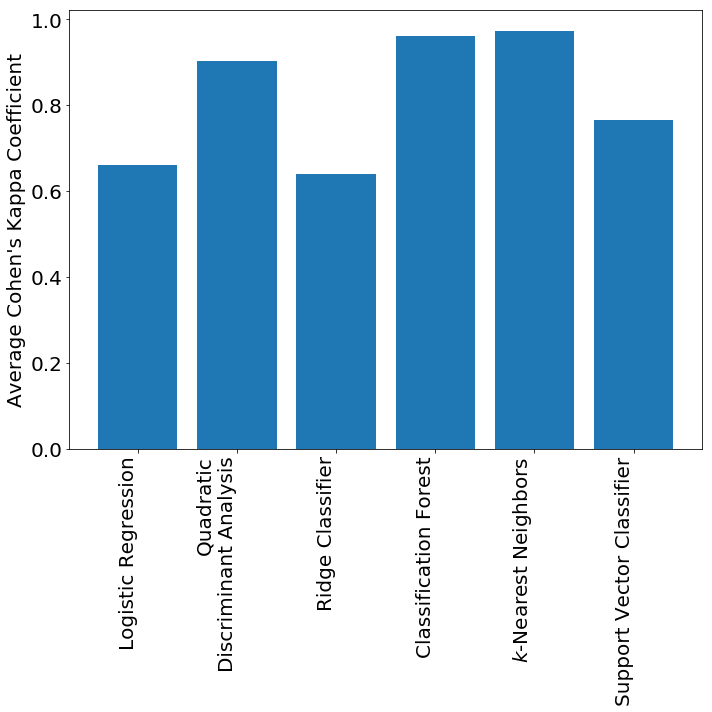

In [63]:
# create and pretty-fy the plot
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.set_ylabel("Average Cohen's Kappa Coefficient", fontsize=20)
plt.xticks(rotation=90, size=20, horizontalalignment="right")
plt.yticks(size=20)

models = {
    "LR": "Logistic Regression",
    # "LDA": "Linear\nDiscriminant Analsis",
    "QDA": "Quadratic\nDiscriminant Analysis",
    "RC": "Ridge Classifier",
    "RFC": "Classification Forest",
    "KNN": "$k$-Nearest Neighbors",
    "SVC": "Support Vector Classifier",
    # "BC": "Bayesian Classifier"
}

# we'll need to compute these
avg_scores = []

# for each model category...
for model in models:
    avg_scores.append(np.mean(results.loc[results["Model"] == model]["Score"].astype(float)))

# plot it
ax.bar(models.values(), avg_scores)

fig.tight_layout()
fig.savefig("figures/ck-bar.png", dpi=200)

# Display the best versions of each model

In [64]:
# we'll need these soon
best_results = pd.DataFrame([])
all_model_names = ["LR", "LDA", "QDA", "RC", "RFC", "KNN", "SVC", "BC"]

# grab the best versions of each model
for model in all_model_names:
    this_model = results.sort_values(by=["Score"], ascending=False).loc[results["Model"] == model]
    best_results = best_results.append(this_model.head(1))

# honestly, we only care about the best of the best
display(best_results.sort_values(by=["Score"], ascending=False))

,Model,Score,Metadata 1,Metadata 2,Metadata 3
164,SVC,1.0,c: 215.443469,rbf,-
84,KNN,0.9983175375699282,neighbors: 1,-,-
72,RFC,0.9979815413172709,max depth: 15,best features: ['X Acceleration'],max features: 1
20,QDA,0.9593097088424087,num features: 5,"best features: ['Roll', 'Pitch', 'Airspeed', 'X Acceleration', 'Z Acceleration']",-
174,BC,0.9113398176177461,-,-,-
6,LR,0.7055913532689831,num features: 7,"best features: ['Roll', 'Pitch', 'Altitude', 'Airspeed', 'Vertical Velocity', 'X Acceleration', 'Z Acceleration']",-
13,LDA,0.6938547939057718,num features: 6,"best features: ['Pitch', 'Altitude', 'Airspeed', 'Vertical Velocity', 'X Acceleration', 'Z Acceleration']",-
32,RC,0.6573698915107461,alpha: 1.274275,-,-


# Test the best versions of each model

In [68]:
# logistic regression
lr_features = ["Roll", "Pitch", "Altitude", "Airspeed", "Vertical Velocity", "X Acceleration", "Z Acceleration"]
model = LR(solver="liblinear", multi_class="ovr", random_state=random_state)
model.fit(train_x[lr_features], train_y)
print("Logistic regression:\n\tLayman:\t{}, {}\n\tExpert:\t{}, {}".format(
    ck_score(test_y, model.predict(test_x[lr_features])),
    accuracy(test_y, model.predict(test_x[lr_features])),
    ck_score(test_expert, model.predict(test_x[lr_features])),
    accuracy(test_expert, model.predict(test_x[lr_features]))
))

# quadratic discriminant analysis
qda_features = ["Roll", "Pitch", "Airspeed", "X Acceleration", "Z Acceleration"]
model = QDA()
model.fit(train_x[qda_features], train_y)
print("Quadratic discriminant analysis:\n\tLayman:\t{}, {}\n\tExpert:\t{}, {}".format(
    ck_score(test_y, model.predict(test_x[qda_features])),
    accuracy(test_y, model.predict(test_x[qda_features])),
    ck_score(test_expert, model.predict(test_x[qda_features])),
    accuracy(test_expert, model.predict(test_x[qda_features]))
))

# remaining models
models = {
    "Ridge": RC(alpha=1.274275, random_state=random_state),
    "Classification tree": RFC(max_depth=9, max_features=2, n_estimators=100, random_state=random_state),
    "k-nearest neighbors": KNN(n_neighbors=3),
    "Support vector classifier": SVC(kernel="rbf", C=215.443469)
}

for model in models:
    models[model].fit(train_x, train_y)
    print("{}:\n\tLayman:\t{}, {}\n\tExpert:\t{}, {}".format(
        model,
        ck_score(test_y, models[model].predict(test_x)),
        accuracy(test_y, models[model].predict(test_x)),
        ck_score(test_expert, models[model].predict(test_x)),
        accuracy(test_expert, models[model].predict(test_x))
    ))

Logistic regression:
	Layman:	0.696015260703688, 0.8027827786891537
	Expert:	0.6771747708371274, 0.7829773532489254
Quadratic discriminant analysis:
	Layman:	0.957673824441876, 0.9734425889083597
	Expert:	0.9275290114830792, 0.9515117398437153
Ridge:
	Layman:	0.6573698915107461, 0.7775593139911475
	Expert:	0.631847381267532, 0.7525350931151049
Classification tree:
	Layman:	0.9969725027716524, 0.9979550102249489
	Expert:	0.9003451251078516, 0.9334798349896257
k-nearest neighbors:
	Layman:	0.9939461856097056, 0.9961335166001767
	Expert:	0.8973302711044682, 0.9314838270055938
Support vector classifier:
	Layman:	0.9939461856097056, 0.9961335166001767
	Expert:	0.8973302711044682, 0.9314838270055938


# Test the best versions without roll, pitch, and yaw

In [69]:
# logistic regression
lr_features = ["Altitude", "Airspeed", "Vertical Velocity", "X Acceleration", "Z Acceleration"]
model = LR(solver="liblinear", multi_class="ovr", random_state=random_state)
model.fit(train_x[lr_features], train_y)
print("Logistic regression:\n\tLayman:\t{}, {}\n\tExpert:\t{}, {}".format(
    ck_score(test_y, model.predict(test_x[lr_features])),
    accuracy(test_y, model.predict(test_x[lr_features])),
    ck_score(test_expert, model.predict(test_x[lr_features])),
    accuracy(test_expert, model.predict(test_x[lr_features]))
))

# quadratic discriminant analysis
qda_features = ["Airspeed", "X Acceleration", "Z Acceleration"]
model = QDA()
model.fit(train_x[qda_features], train_y)
print("Quadratic discriminant analysis:\n\tLayman:\t{}, {}\n\tExpert:\t{}, {}".format(
    ck_score(test_y, model.predict(test_x[qda_features])),
    accuracy(test_y, model.predict(test_x[qda_features])),
    ck_score(test_expert, model.predict(test_x[qda_features])),
    accuracy(test_expert, model.predict(test_x[qda_features]))
))

# remaining models
models = {
    "Ridge": RC(alpha=1.274275, random_state=random_state),
    "Classification tree": RFC(max_depth=9, max_features=2, n_estimators=100, random_state=random_state),
    "k-nearest neighbors": KNN(n_neighbors=3),
    "Support vector classifier": SVC(kernel="rbf", C=215.443469)
}

for model in models:
    models[model].fit(train_x.drop(columns=["Roll", "Pitch"]), train_y.drop(columns=["Roll", "Pitch"]))
    print("{}:\n\tLayman:\t{}, {}\n\tExpert:\t{}, {}".format(
        model,
        ck_score(test_y, models[model].predict(test_x.drop(columns=["Roll", "Pitch"]))),
        accuracy(test_y, models[model].predict(test_x.drop(columns=["Roll", "Pitch"]))),
        ck_score(test_expert, models[model].predict(test_x.drop(columns=["Roll", "Pitch"]))),
        accuracy(test_expert, models[model].predict(test_x.drop(columns=["Roll", "Pitch"])))
    ))

Logistic regression:
	Layman:	0.6567637971769552, 0.7756698094517706
	Expert:	0.6379793859489383, 0.756660132234703
Quadratic discriminant analysis:
	Layman:	0.7394393356875129, 0.8350895172386946
	Expert:	0.7195770084816715, 0.8137986412698162
Ridge:
	Layman:	0.5876842398478848, 0.72918386828469
	Expert:	0.5649308806186093, 0.7078379927775477
Classification tree:
	Layman:	0.9939461856097056, 0.9961335166001767
	Expert:	0.8973302711044682, 0.9314838270055938
k-nearest neighbors:
	Layman:	0.9848673072941406, 0.9902830238318682
	Expert:	0.8943080045205429, 0.9293407007016531
Support vector classifier:
	Layman:	0.9939461856097056, 0.9961335166001767
	Expert:	0.8973302711044682, 0.9314838270055938
